- Yari 
- competitor data mergen
- Histogrammen voor aantal variabelen

- Silver
- Onnodige kolommen verwijderen
- Data down- en upsamplen
- Outliers verwijderen
- down and upsample, First outliers, then create features

In [1]:
import pprint as pp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

training_samples = pd.read_csv("vu-dmt-assigment-2-2023/training_set_VU_DM.csv")
test_samples = pd.read_csv("vu-dmt-assigment-2-2023/test_set_VU_DM.csv")

In [2]:
training_samples.info()
training_samples.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4958347 entries, 0 to 4958346
Data columns (total 54 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   srch_id                      int64  
 1   date_time                    object 
 2   site_id                      int64  
 3   visitor_location_country_id  int64  
 4   visitor_hist_starrating      float64
 5   visitor_hist_adr_usd         float64
 6   prop_country_id              int64  
 7   prop_id                      int64  
 8   prop_starrating              int64  
 9   prop_review_score            float64
 10  prop_brand_bool              int64  
 11  prop_location_score1         float64
 12  prop_location_score2         float64
 13  prop_log_historical_price    float64
 14  position                     int64  
 15  price_usd                    float64
 16  promotion_flag               int64  
 17  srch_destination_id          int64  
 18  srch_length_of_stay          int64  
 19  

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,...,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0


In [3]:
test_samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4959183 entries, 0 to 4959182
Data columns (total 50 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   srch_id                      int64  
 1   date_time                    object 
 2   site_id                      int64  
 3   visitor_location_country_id  int64  
 4   visitor_hist_starrating      float64
 5   visitor_hist_adr_usd         float64
 6   prop_country_id              int64  
 7   prop_id                      int64  
 8   prop_starrating              int64  
 9   prop_review_score            float64
 10  prop_brand_bool              int64  
 11  prop_location_score1         float64
 12  prop_location_score2         float64
 13  prop_log_historical_price    float64
 14  price_usd                    float64
 15  promotion_flag               int64  
 16  srch_destination_id          int64  
 17  srch_length_of_stay          int64  
 18  srch_booking_window          int64  
 19  

In [4]:
# No duplicates rows exist in the training samples
training_samples[training_samples.duplicated()]

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool


Training samples and the test samples have almost the same amount of rows.

### Missing Data

<AxesSubplot:>

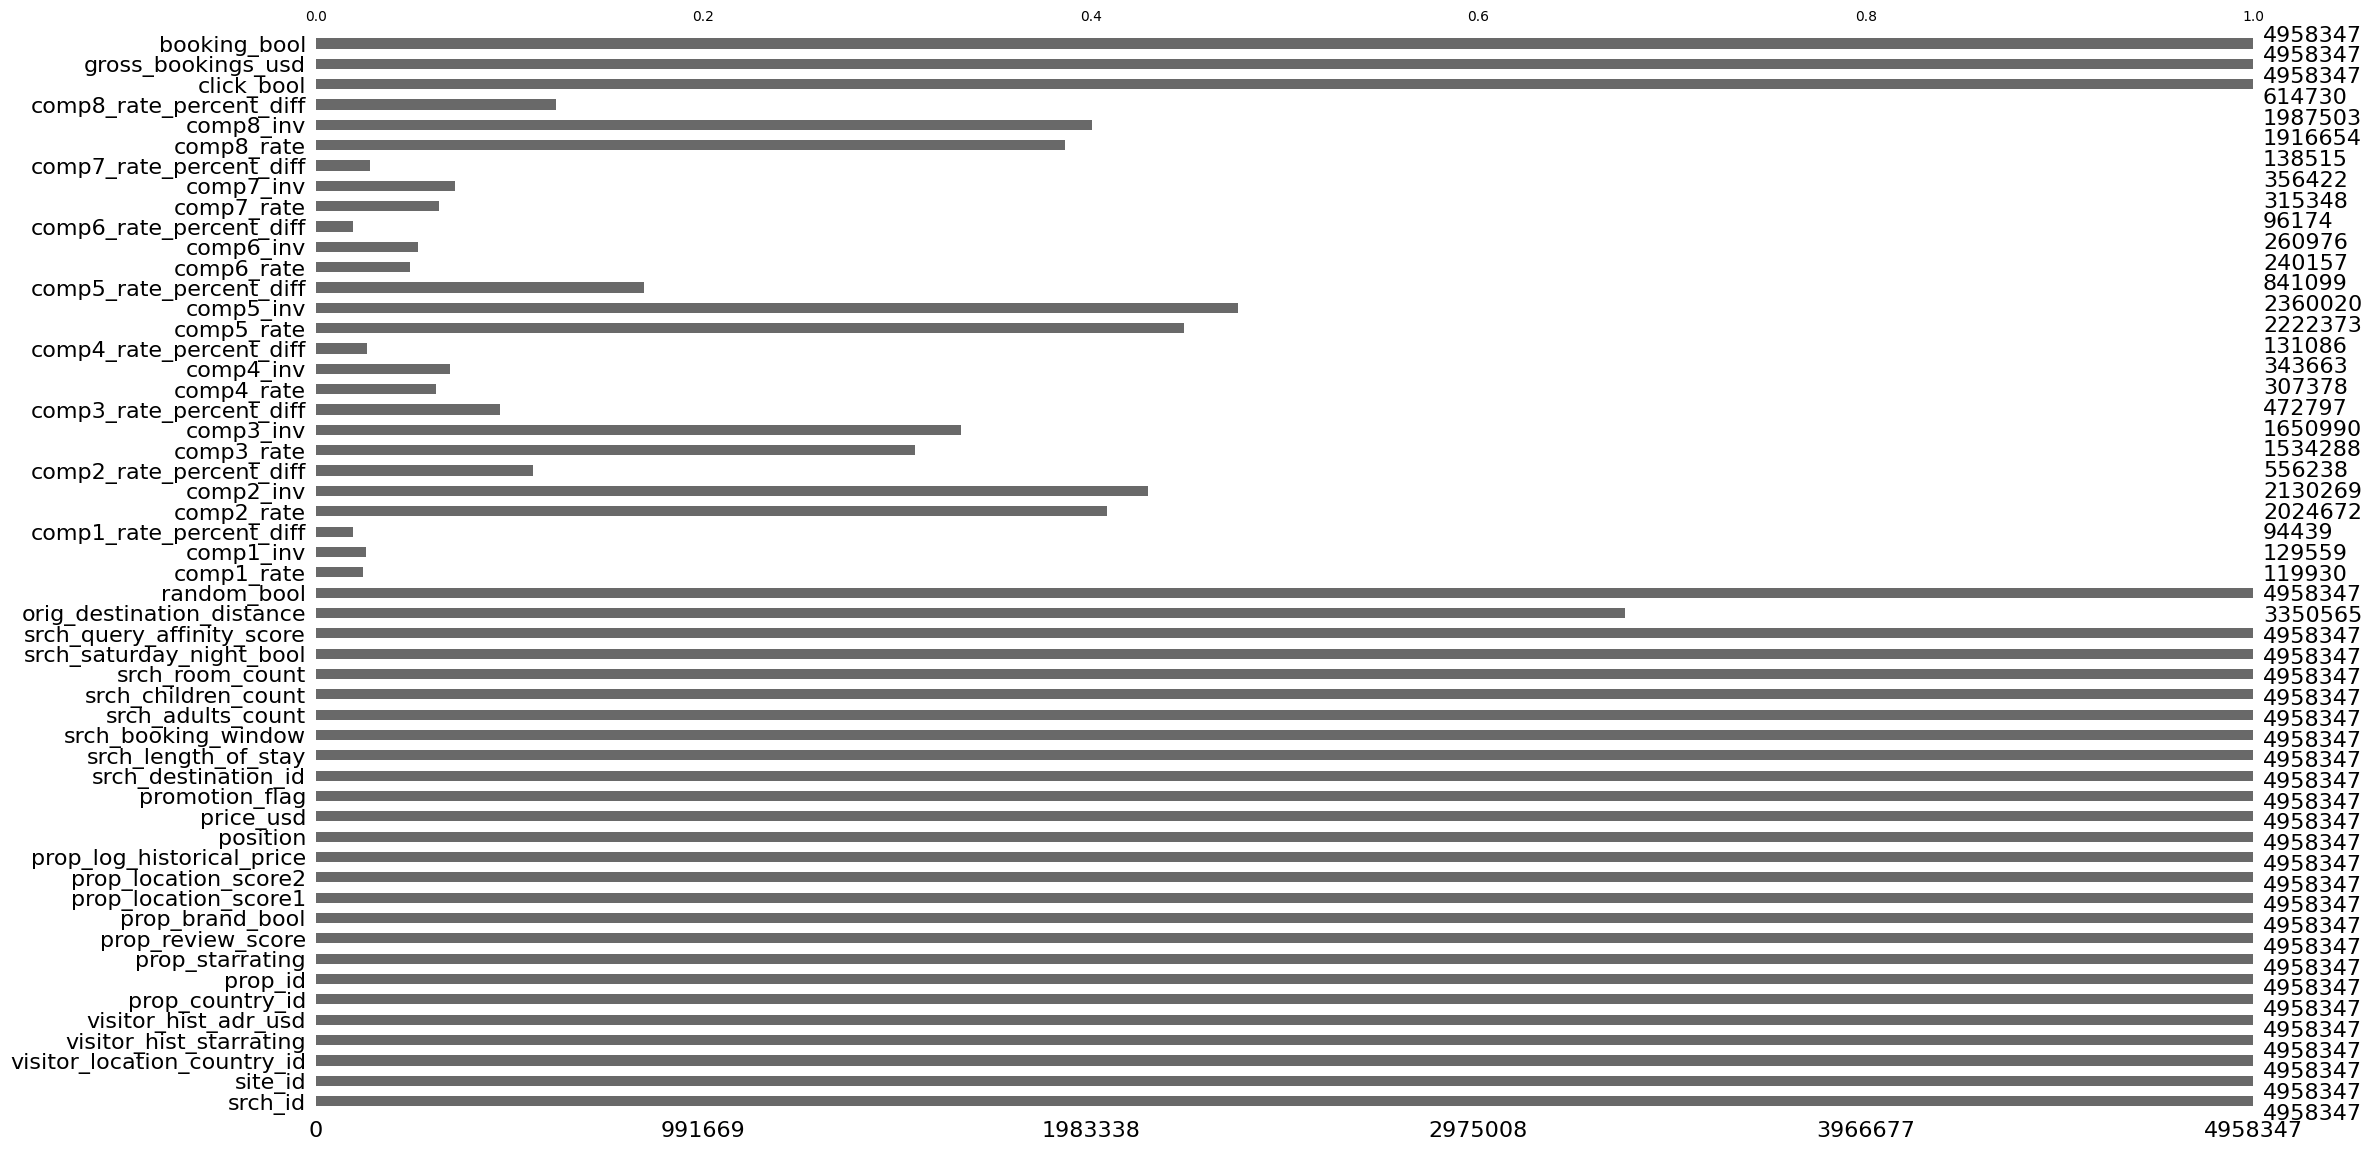

In [221]:
import missingno as msno

# Show how complete each variable it
msno.bar(training_samples)

In [222]:
training_samples.isna().sum()

srch_id                              0
site_id                              0
visitor_location_country_id          0
visitor_hist_starrating              0
visitor_hist_adr_usd                 0
prop_country_id                      0
prop_id                              0
prop_starrating                      0
prop_review_score                    0
prop_brand_bool                      0
prop_location_score1                 0
prop_location_score2                 0
prop_log_historical_price            0
position                             0
price_usd                            0
promotion_flag                       0
srch_destination_id                  0
srch_length_of_stay                  0
srch_booking_window                  0
srch_adults_count                    0
srch_children_count                  0
srch_room_count                      0
srch_saturday_night_bool             0
srch_query_affinity_score            0
orig_destination_distance      1607782
random_bool              

In [223]:
# Some variables we can set to 0 rather than 0
set_zero = ["prop_review_score", "visitor_hist_adr_usd", "srch_query_affinity_score"
           , "prop_location_score2", "gross_bookings_usd"]
training_samples[set_zero] = training_samples[set_zero].fillna(0)

We can see that many comp variables have more than half of the rows missing, which is quite a lot. If we want to impute this data we would have a lot of artificial data that might not be correct according to reality. Therefore, we will remove columns that have more than half of the total rows missing.

In [224]:
# missing_mask = training_samples.isna().sum() > 2500000
# clean_training = training_samples.drop(training_samples.loc[:,missing_mask], axis=1)
# clean_training.isna().sum()

We are now left with many columns that have no NaN values or less than half of the total rows. prop_review_score has a low number of missing values, so we can impute these values. prop_location_score2 has a quite large number of missing values ~20%. We already have prop_location_score1 which describes something similar, according to the description. Therefore, we assume that the amount of information this variable might add might be excessive. 

orig_destination_distance is the physical distance between the hotel and the customer at the time of search. This variable does not seem very informative in combination with the number of missing values ~25% of the total set.

In [308]:
removing_cols = ["price_usd", "prop_log_historical_price", "srch_children_count", "position", "srch_destination_id", 
                "orig_destination_distance", "promotion_flag", "random_bool", 
                 "srch_query_affinity_score", "srch_booking_window", "visitor_hist_starrating"]
clean_training2 = training_samples.drop(removing_cols, axis=1)

In [309]:
# Fill missing competitor data with zeros
cols = [c for c in clean_training2.columns if "comp" in c]
clean_training2[cols] = clean_training2[cols].fillna(0)

In [310]:
rates = [col for col in clean_training2.columns if "_rate" in col and "percent" not in col and "rates" not in col]
rate_percents = [col for col in clean_training2.columns if "_rate_" in col]
invs = [col for col in clean_training2.columns if "_inv" in col]

# Invs are clean
for i in invs:
    print(clean_training2[i].unique())

# Rates are clean
for i in rates:
    print(clean_training2[i].unique())
    
# Rates are over 100%, thus we clean those not in range.
for i in rate_percents:
    mean_value = clean_training2[clean_training2[i] <= 100][i].mean()
    clean_training2.loc[clean_training2[i] > 100, i] = mean_value

[ 0.  1. -1.]
[ 0.  1. -1.]
[ 0.  1. -1.]
[ 0.  1. -1.]
[ 0.  1. -1.]
[ 0.  1. -1.]
[ 0.  1. -1.]
[ 0.  1. -1.]
[ 0.  1. -1.]
[ 0. -1.  1.]
[ 0. -1.  1.]
[ 0.  1. -1.]
[ 0.  1. -1.]
[ 0.  1. -1.]
[ 0.  1. -1.]
[ 0. -1.  1.]


<AxesSubplot:>

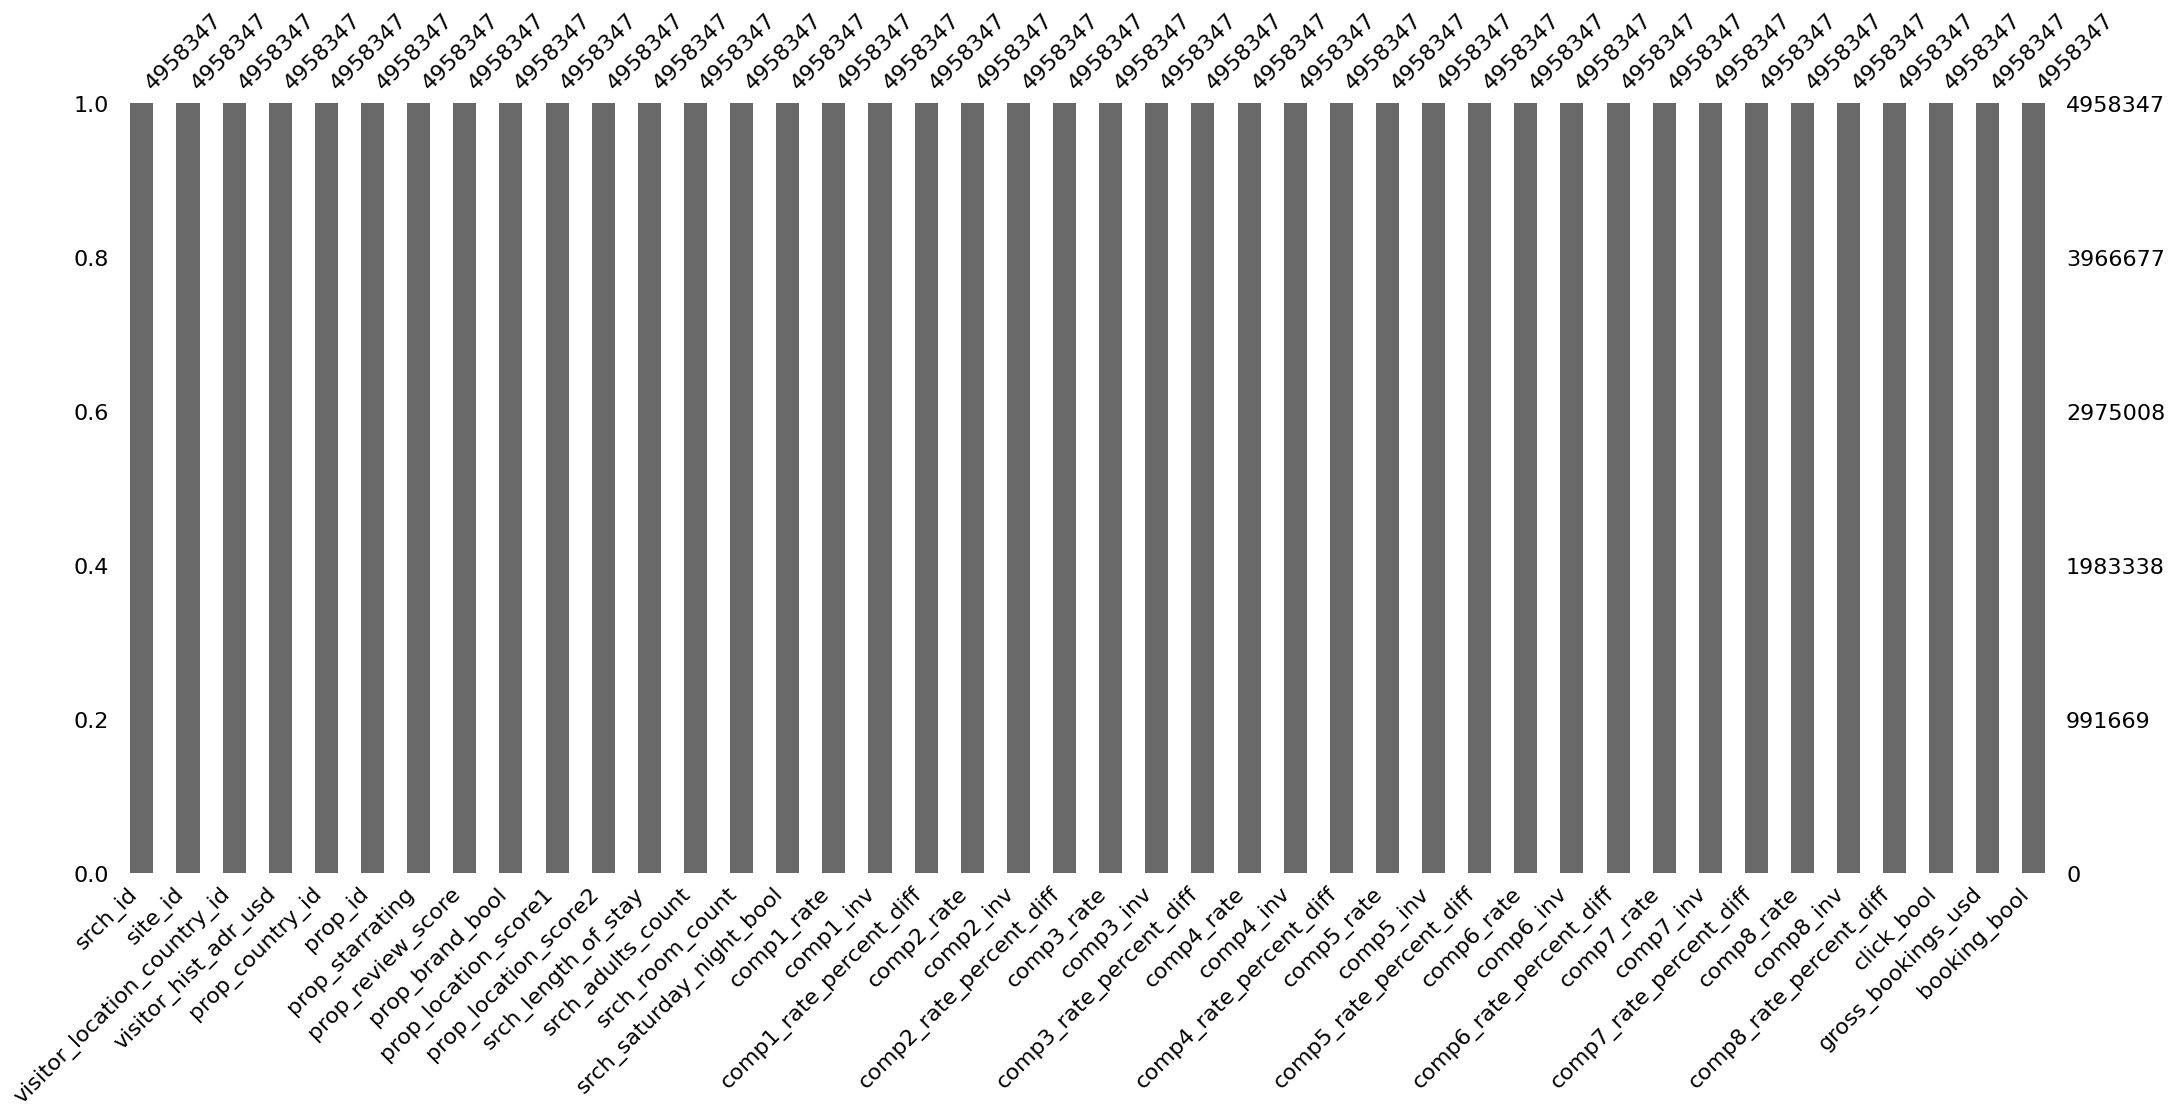

In [311]:
msno.bar(clean_training2)

In order to get a better understanding of the distribution of our data, outlier detection would be a necessary step to evaluate the data. In our model we will treat outliers as missing values, this way we can have enough data to work with without the need to remove a lot of datapoints.

In [312]:
def plot_correlation(df):
    plt.figure(figsize = (24, 12))
    corr = df.corr()
    sns.heatmap(corr, annot = True, linewidths = 1)
    plt.show()
    return corr['booking_bool'].abs().sort_values(ascending = False)

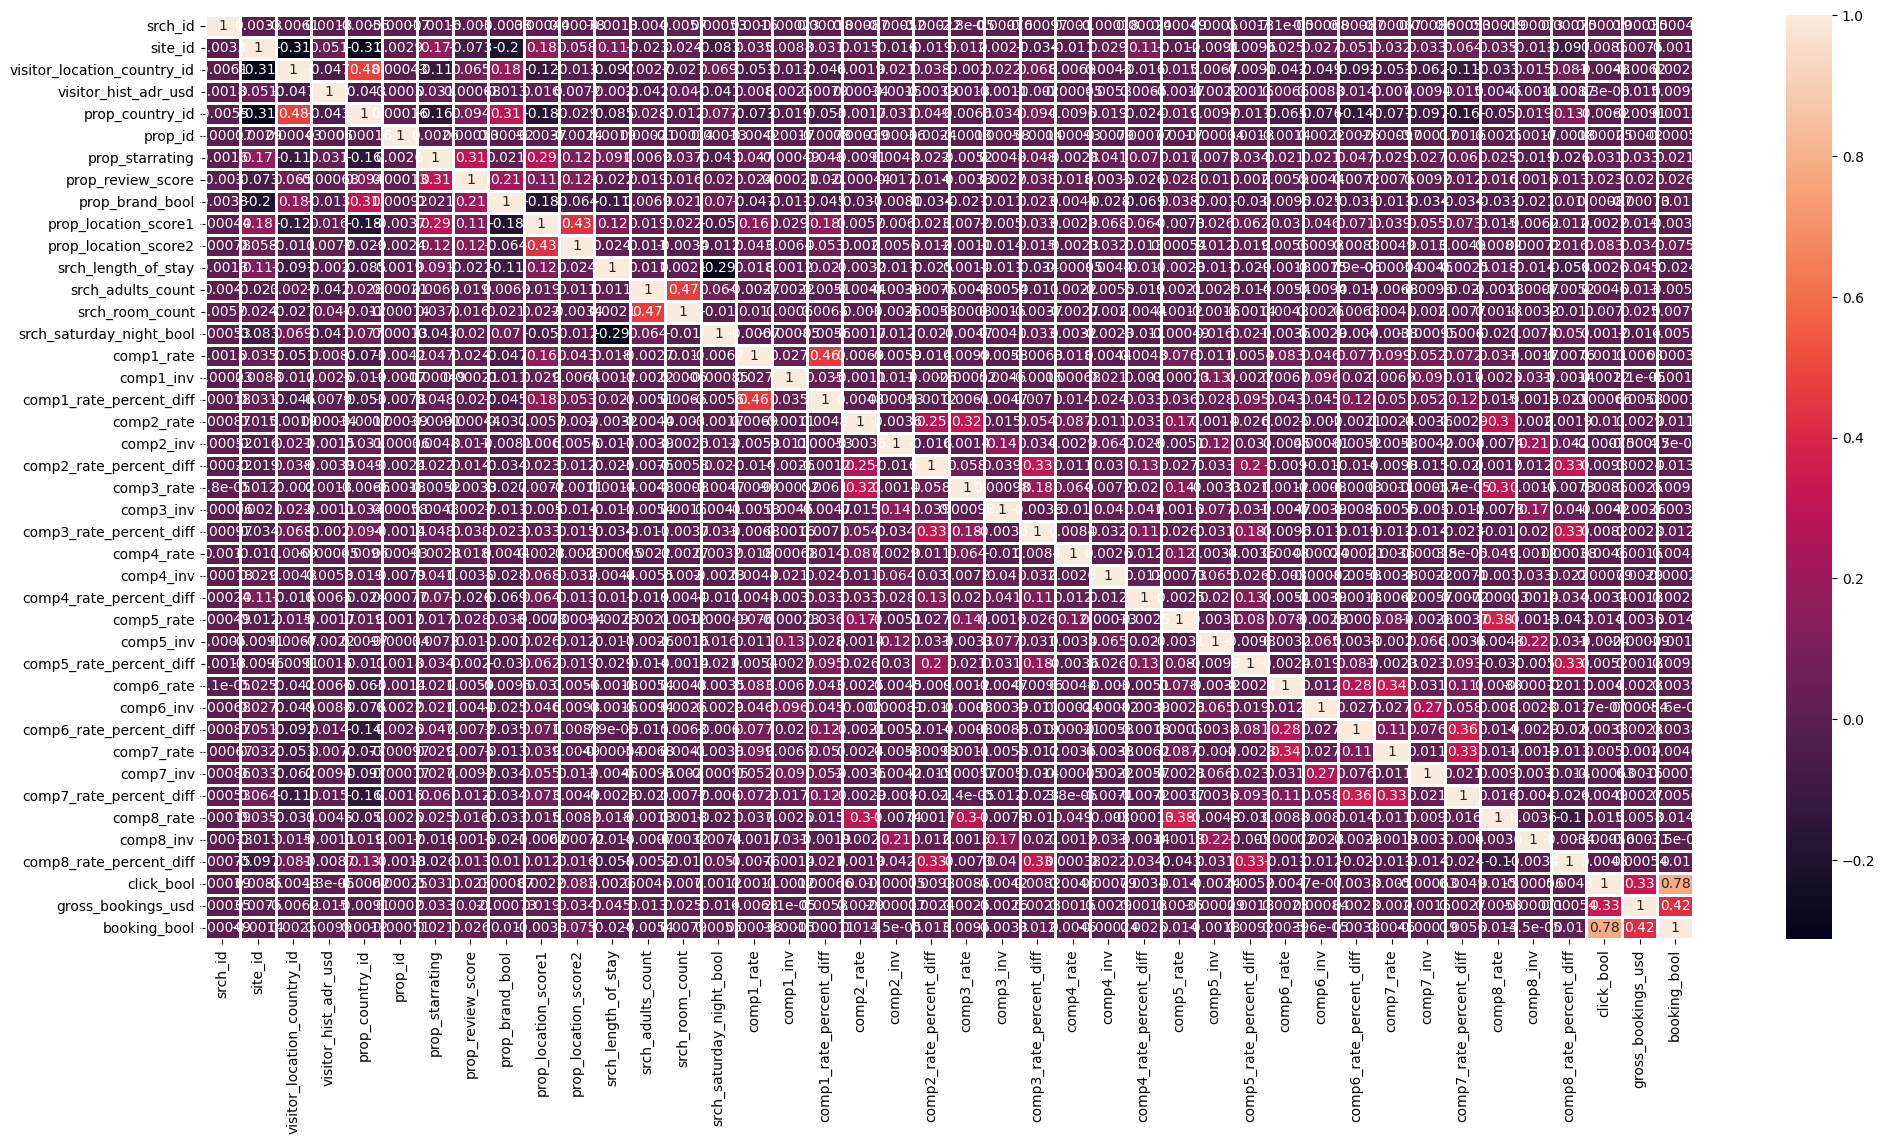

booking_bool                   1.000000
click_bool                     0.782889
gross_bookings_usd             0.420738
prop_location_score2           0.075437
prop_review_score              0.025936
srch_length_of_stay            0.024412
prop_starrating                0.021206
comp8_rate                     0.014344
comp5_rate                     0.014257
comp2_rate_percent_diff        0.012579
comp3_rate_percent_diff        0.012381
comp2_rate                     0.010881
comp8_rate_percent_diff        0.010277
prop_brand_bool                0.009991
visitor_hist_adr_usd           0.009861
comp3_rate                     0.009527
comp5_rate_percent_diff        0.009182
srch_room_count                0.007948
comp7_rate_percent_diff        0.005552
srch_saturday_night_bool       0.005478
srch_adults_count              0.005376
comp7_rate                     0.004594
comp4_rate                     0.004484
comp6_rate                     0.003868
comp6_rate_percent_diff        0.003773


In [313]:
res = plot_correlation(clean_training2)
res

In [314]:
correlation = corr['booking_bool'].abs().sort_values(ascending = False)
correlation

booking_bool                   1.000000
click_bool                     0.782889
prop_location_score2           0.066405
prop_review_score              0.025936
srch_length_of_stay            0.024412
comp8_rate                     0.023607
prop_starrating                0.021206
comp5_rate                     0.020827
comp4_rate                     0.017926
comp3_rate                     0.016315
comp2_rate                     0.016217
comp6_rate                     0.011455
comp7_rate                     0.011432
visitor_hist_starrating        0.011123
comp1_rate                     0.010133
prop_brand_bool                0.009991
visitor_hist_adr_usd           0.009861
srch_room_count                0.007948
comp1_inv                      0.007850
comp3_inv                      0.007438
comp7_inv                      0.006155
comp6_inv                      0.005906
comp7_rate_percent_diff        0.005602
srch_saturday_night_bool       0.005478
srch_adults_count              0.005376


In [315]:
clean_training2["prop_location_score2"].unique()

array([0.0438, 0.0149, 0.0245, ..., 0.6079, 0.8922, 0.8995])

WORKS KINDA:
    
    - prop_location_score1, prop_location_score2: CORRELATION - prop_score
    - gross_bookings_usd, srch_length_of_stay: CORRELATION - booking_stay

NOT WORKING:

    - prop_starrating, prop_review_score: LIGHT CORRELATION
    - prop_country_id, visitor_location_country_id: CORRELATION
    - visitor_hist_adr_usd, visitor_hist_starrating: BIG CORRELATION, DOESNT WORK
    - srch_room_count, srch_adults_count: CORRELATION, intuitively not really a predictor or booking_bool
    - srch_saturday_night_bool, srch_length_of_stay: INVERSE CORRELATION, searching doesnt predict booking per se

In [316]:
# Prop scores - 0.1167 correlation with booking_bool
# clean_training2["prop_score"] = clean_training2["prop_location_score2"]/clean_training2["prop_location_score1"]

# booking_stay - SUCCESS 0.62
clean_training2["booking_stay"] = clean_training2["gross_bookings_usd"] / clean_training2["srch_length_of_stay"]


In [317]:
rates = [col for col in clean_training2.columns if "_rate" in col and "percent" not in col and "rates" not in col]
rate_percents = [col for col in clean_training2.columns if "_rate_" in col]
invs = [col for col in clean_training2.columns if "_inv" in col]

In [318]:
# Remove all the cols
clean_training2 = clean_training2.drop(rates+rate_percents+invs, axis=1)

In [319]:
# clean_training2[rates] = clean_training2[rates].fillna(0)
# clean_training2[rate_percents] = clean_training2[rate_percents].fillna(0)
# clean_training2[invs] = clean_training2[invs].fillna(0)

# clean_training2["all_comp_rates"] = clean_training2[rates].sum(axis=1)
# clean_training2["all_comp_percents"] = clean_training2[rate_percents].sum(axis=1)
# clean_training2["all_invs"] = clean_training2[invs].sum(axis=1)

# clean_training2["all_comps"] = (clean_training2["all_invs"] + clean_training2["all_comp_rates"]) + clean_training2["all_comp_percents"]

# Expedia has a price advantage
# clean_training2['expedia_price_advantage'] = clean_training2['comp1_rate'].apply(lambda x: 1 if x == 1 else 0)
# clean_training2['expedia_price_advantage2'] = clean_training2['expedia_price_advantage'] + clean_training2["all_invs"] * clean_training2["click_bool"]

# Create a feature for each competitor
# for i in range(1, 9):
#     p = 'comp'+str(i)
#     clean_training2[p] = (clean_training2[p+"_rate"] + clean_training2[p+"_inv"]) * clean_training2[p+"_rate_percent_diff"]

# clean_training2["corr"] = clean_training2["prop_brand_bool"] * (clean_training2["prop_location_score1"] + clean_training2["prop_location_score2"])



# Hypothetically
- What could make someone book a property while searching?
- property rating, review score, 
- Competitors combines with 
    - Not the property rating because this is the same at each website
    - 
  
If the place is nice, we rather want to add a weekend
- Prop brand, location scores, prop_country_id, srch_saturday_night_bool,

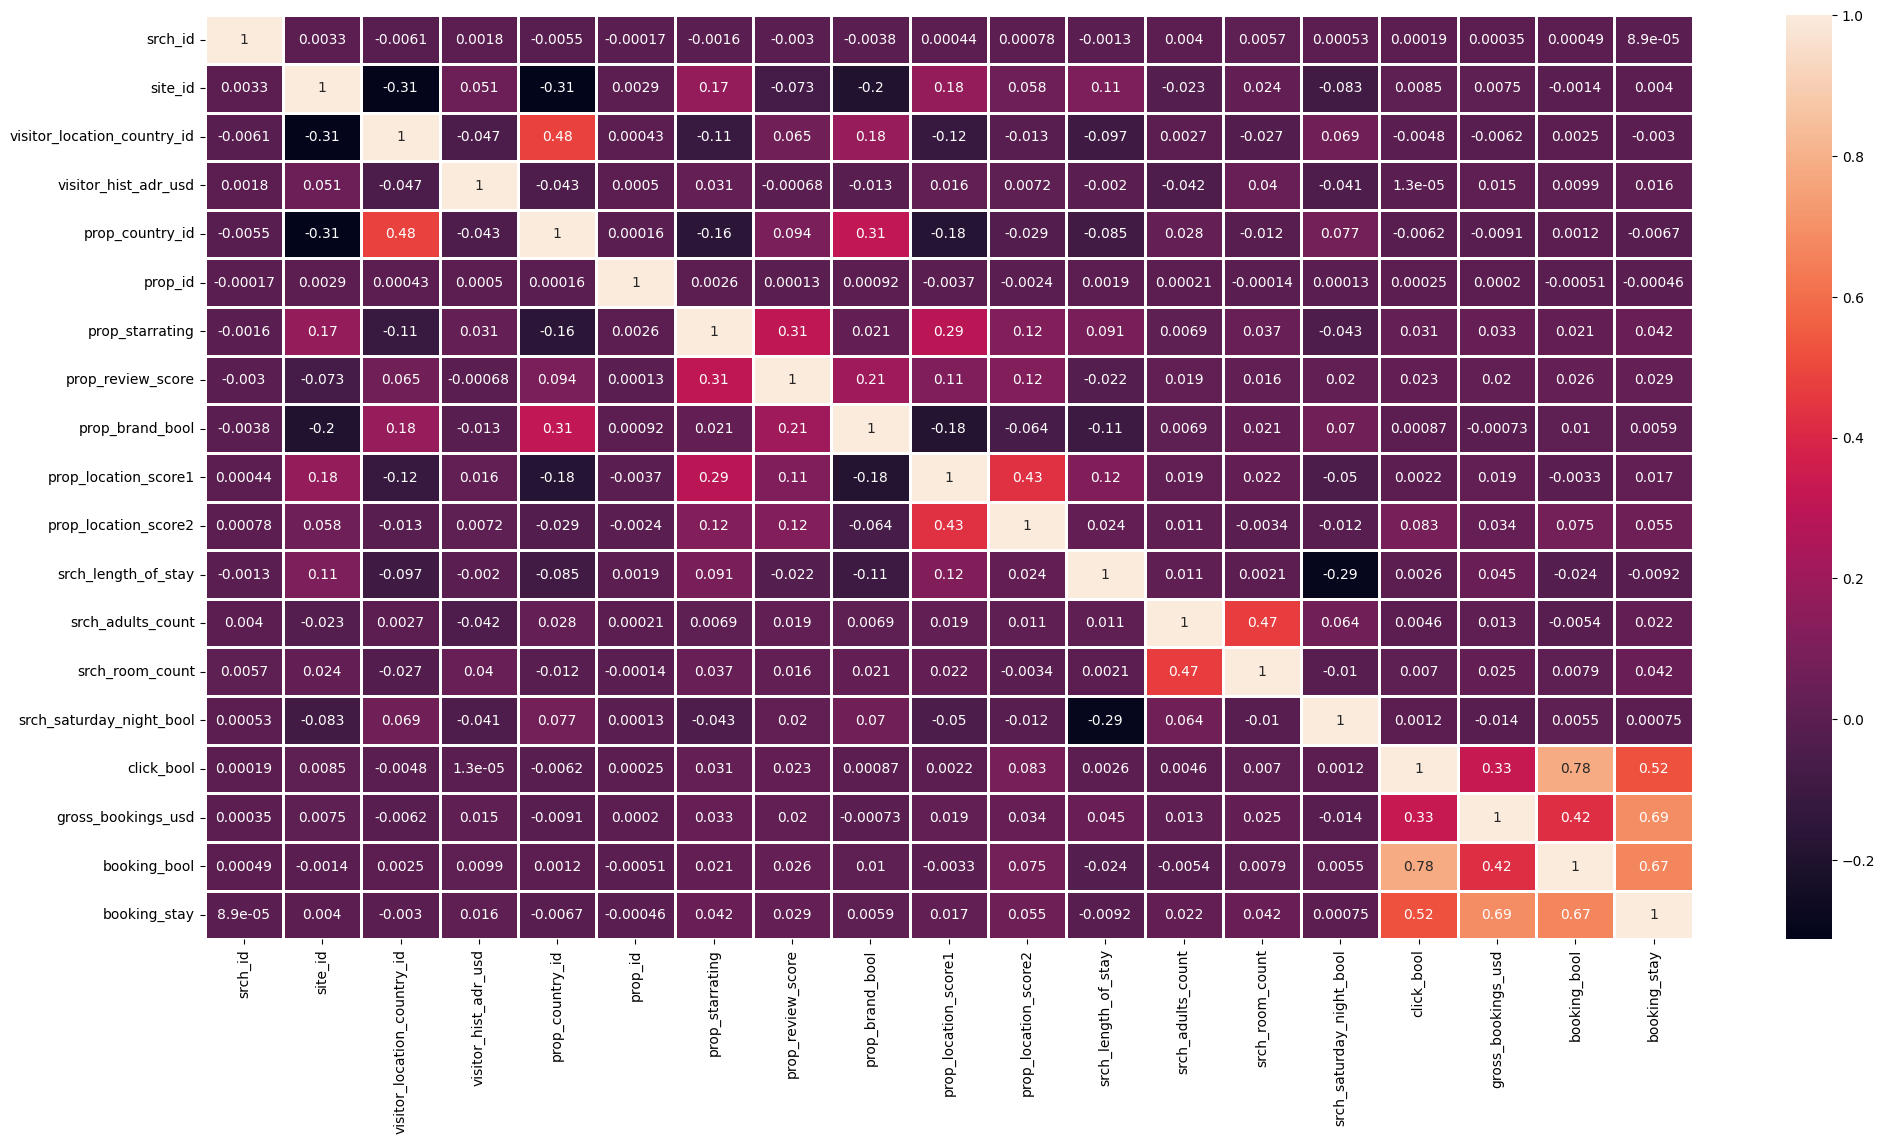

booking_bool                   1.000000
click_bool                     0.782889
booking_stay                   0.668516
gross_bookings_usd             0.420738
prop_location_score2           0.075437
prop_review_score              0.025936
srch_length_of_stay            0.024412
prop_starrating                0.021206
prop_brand_bool                0.009991
visitor_hist_adr_usd           0.009861
srch_room_count                0.007948
srch_saturday_night_bool       0.005478
srch_adults_count              0.005376
prop_location_score1           0.003273
visitor_location_country_id    0.002524
site_id                        0.001354
prop_country_id                0.001227
prop_id                        0.000508
srch_id                        0.000487
Name: booking_bool, dtype: float64

In [320]:
res = plot_correlation(clean_training2)
res

In [321]:
clean_training2.var()

srch_id                        9.237561e+09
site_id                        5.847492e+01
visitor_location_country_id    4.344952e+03
visitor_hist_adr_usd           2.087162e+03
prop_country_id                4.671073e+03
prop_id                        1.649166e+09
prop_starrating                1.104651e+00
prop_review_score              1.122716e+00
prop_brand_bool                2.318561e-01
prop_location_score1           2.343995e+00
prop_location_score2           2.275311e-02
srch_length_of_stay            4.215806e+00
srch_adults_count              7.345566e-01
srch_room_count                1.740800e-01
srch_saturday_night_bool       2.499952e-01
click_bool                     4.274616e-02
gross_bookings_usd             2.286986e+04
booking_bool                   2.713152e-02
booking_stay                   1.840609e+03
dtype: float64

## Distribution plotting

In [322]:
import seaborn as sns
import matplotlib.pyplot as plt

new_training = clean_training2.copy()

float_cols = new_training.select_dtypes(include=["float64"])
int_cols = new_training.select_dtypes(include=["int64"])

# Ids and bools don't have our interest since we know they distribution.
non_id_and_bool_ones = list(float_cols.columns)
count_cols = list(int_cols.columns)


In [323]:
# Plot the counts
def plot_data(df, is_float):
    num_rows = len(df.columns) // 2 + len(df.columns) % 2

    fig, axs = plt.subplots(num_rows, 2, figsize=(10, num_rows*3))

    for i, col in enumerate(df.columns):
        ax = axs.flatten()[i]
        if not is_float:
            sns.histplot(df[col], ax=ax)
        else:
            sns.scatterplot(x=df.index, y=df[col], ax=ax)
        ax.set_title(col)

    # Remove unused subplots
    if len(df.columns) % 2 != 0:
        fig.delaxes(axs.flatten()[-1])

    plt.tight_layout()
    plt.show()

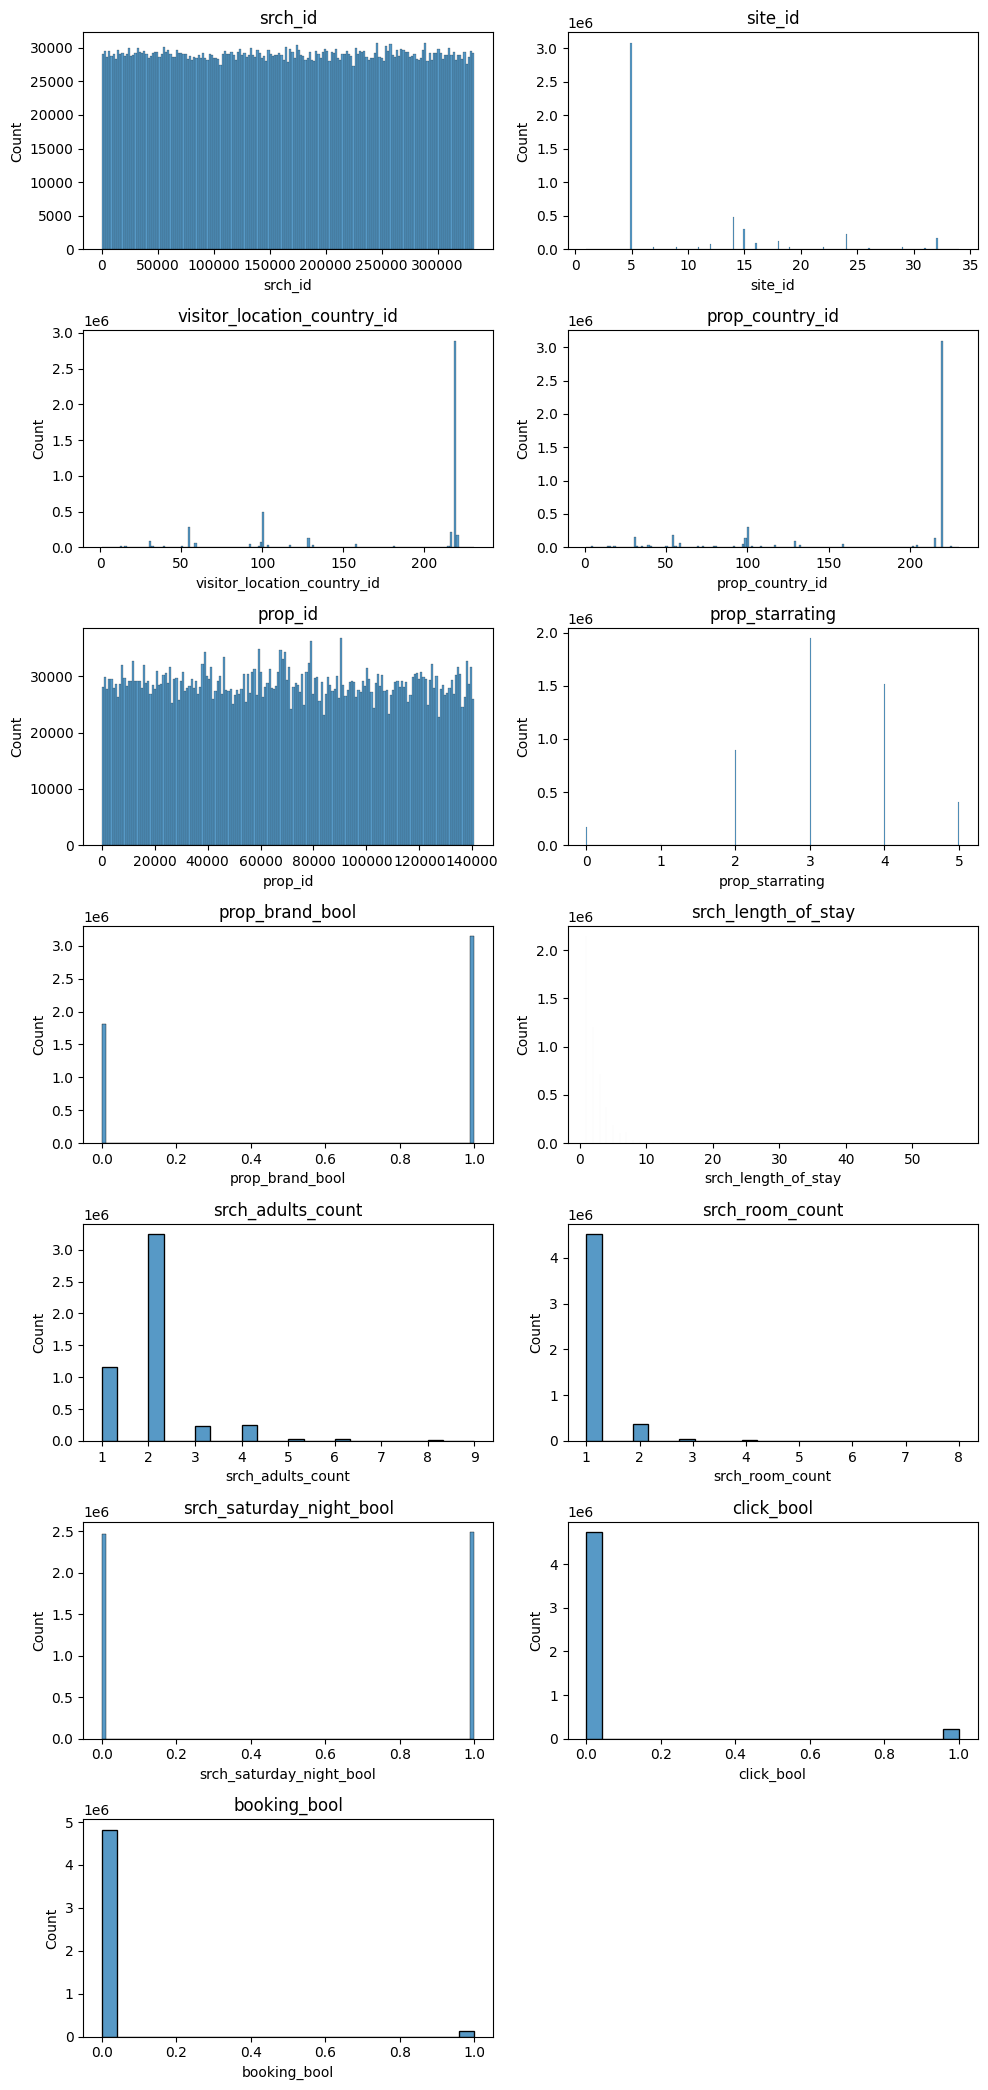

In [324]:
plot_data(new_training[count_cols], False)

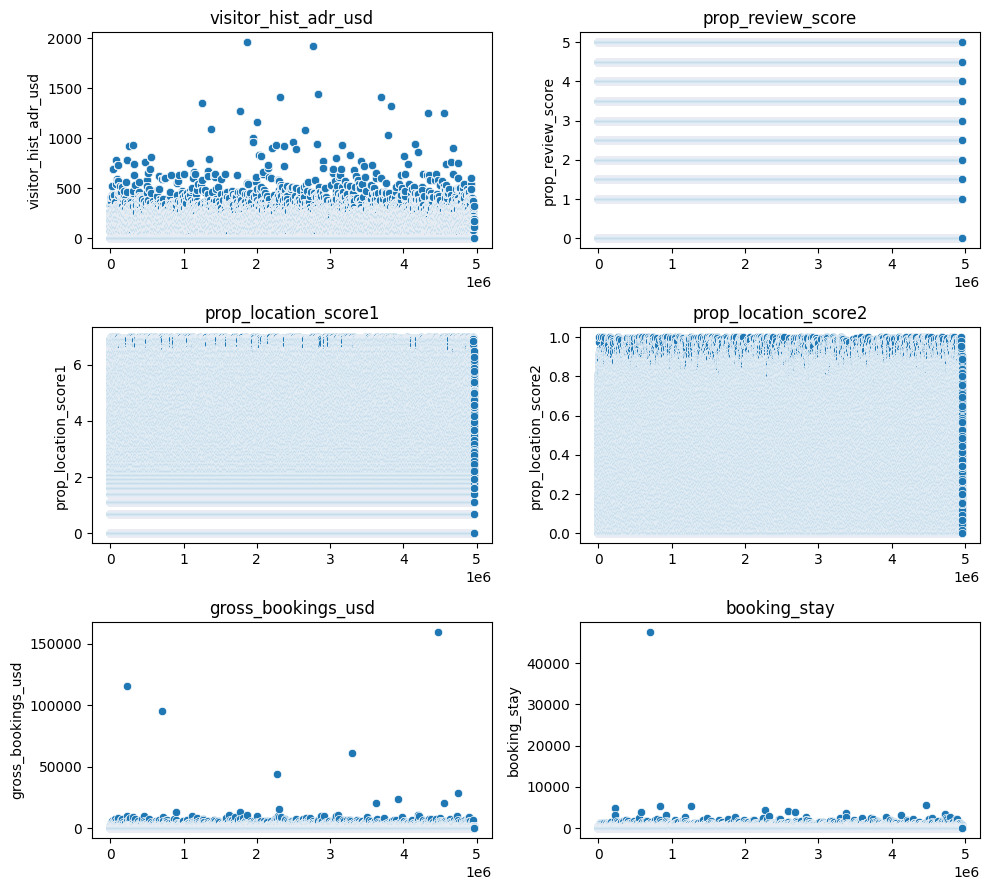

In [325]:
plot_data(clean_training2[non_id_and_bool_ones], True)

In [402]:
clean_training2["booking_stay"].max()

47485.0

From our analysis we can see that price_usd and srch_length_of_stay have some outliers. 

## Down- and upsampling the training dataset
For some data points we need to downsample and for some we need to upsample the data. i.e. when we look at booking bool, that checks whether a hotel is booked, a lot of hotels have not been booked. This would introduce a big bias towards the non-booking side.

In [437]:
# Use SMOTE - Synthetic Minority Over-sampling Technique
from imblearn.over_sampling import SMOTE
from collections import Counter

def oversample_data(df, column, alpha):
    X_train, y_train = df.drop(column, axis=1), df[column]
    smote = SMOTE(random_state=27, sampling_strategy=alpha)
    X, y = smote.fit_resample(X_train, y_train)
    print("Before oversampling: ", Counter(y_train))
    print("After oversampling: ", Counter(y))
    oversampled_df = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis=1)
    return oversampled_df
    

In [438]:
oversampled = oversample_data(new_training, "booking_bool", 0.2)

Before oversampling:  Counter({0: 4819957, 1: 138390})
After oversampling:  Counter({0: 4819957, 1: 963991})


In [439]:
from imblearn.under_sampling import RandomUnderSampler

def undersample_data(df, column, alpha):
    X_train, y_train = df.drop(column, axis=1), df[column]
    smote = RandomUnderSampler(random_state=27, sampling_strategy=alpha)
    X, y = smote.fit_resample(X_train, y_train)
    print("Before undersampling: ", Counter(y_train))
    print("After undersampling: ", Counter(y))
    oversampled_df = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis=1)
    return oversampled_df

In [440]:
undersampled = undersample_data(oversampled, "booking_bool", 0.65)

Before undersampling:  Counter({0: 4819957, 1: 963991})
After undersampling:  Counter({0: 1483063, 1: 963991})


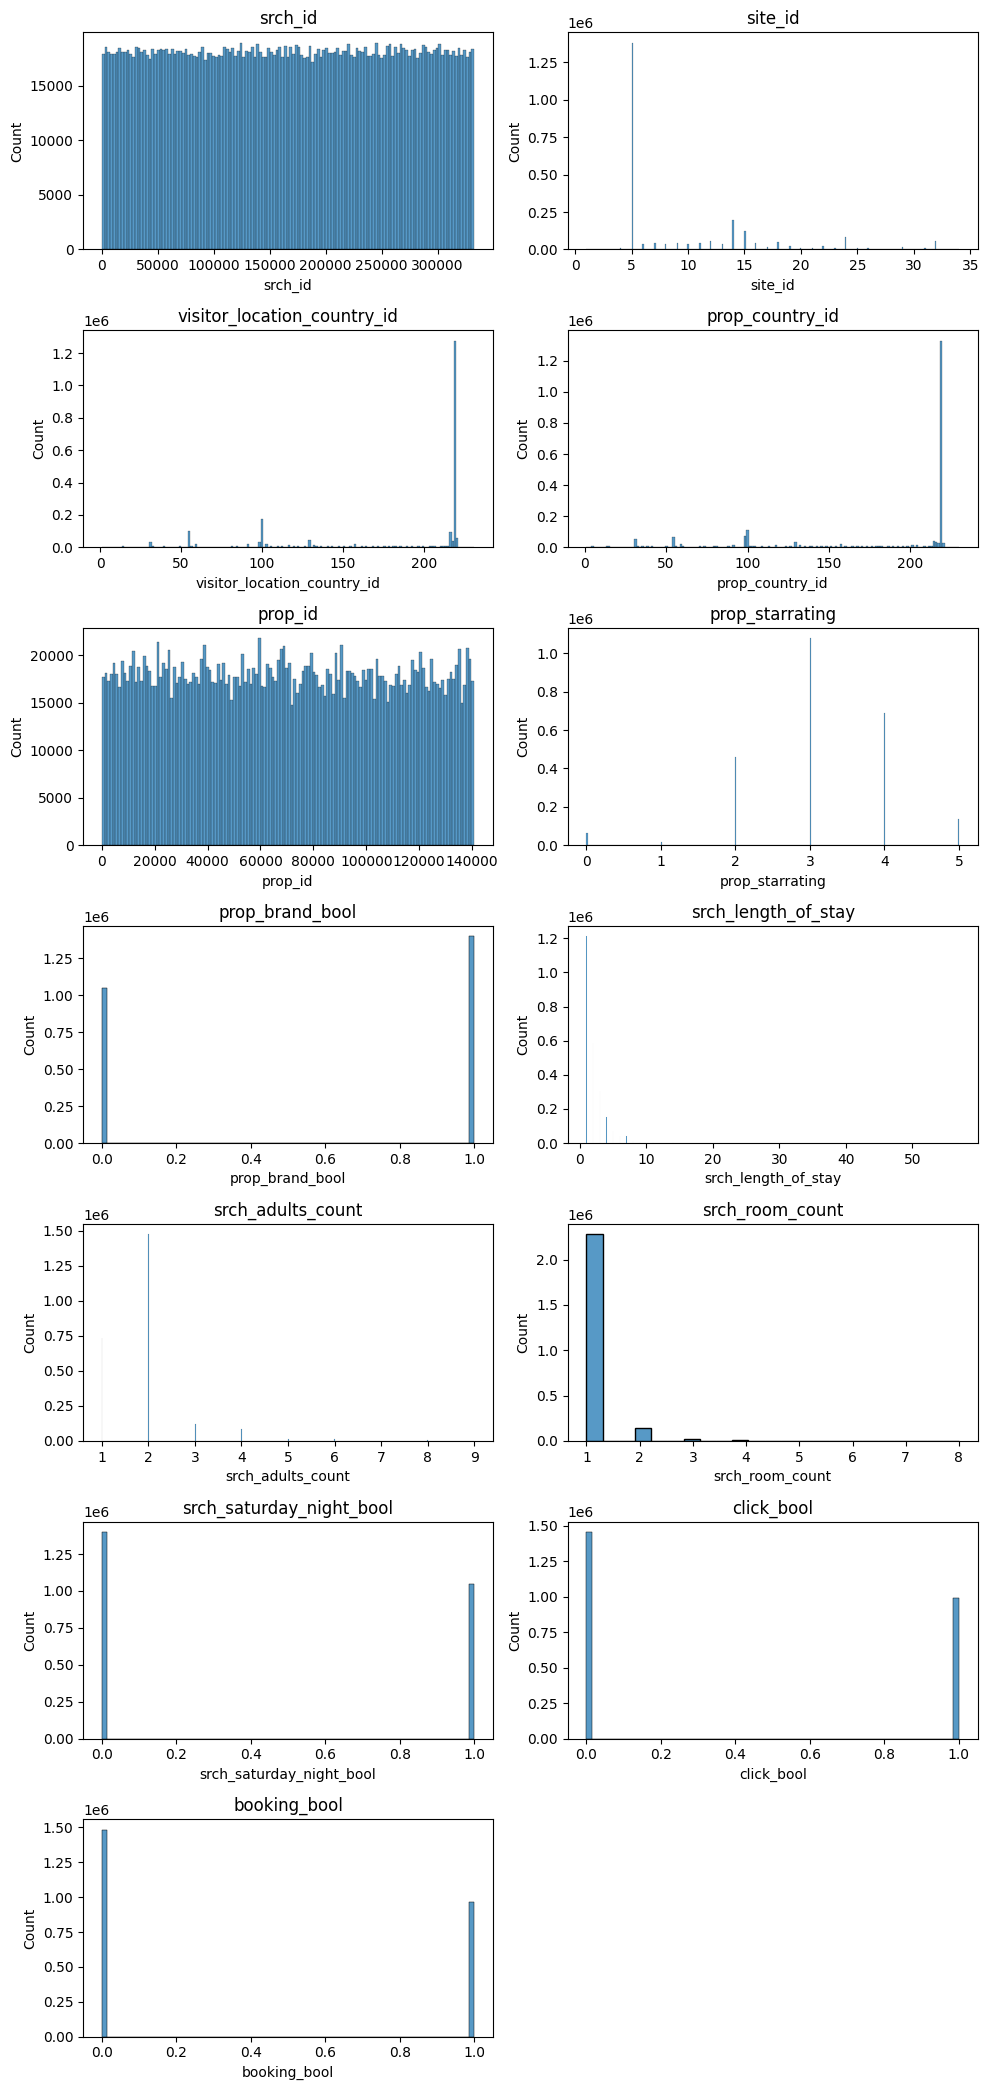

In [441]:
int_cols = undersampled.select_dtypes(include=["int64"])
plot_data(undersampled[int_cols.columns], False)

In [442]:
def undersample_multi_data(df, column, alpha):
    X_train, y_train = df.drop(column, axis=1), df[column]
    
    a, b = Counter(undersampled[column]).most_common()[0]

    # Create a dictionary with the desired sample count for class 4
    sampling_strategy = {}
    sampling_strategy[a] = round(b/3)
    
    rus = RandomUnderSampler(random_state=27, sampling_strategy=sampling_strategy)
    X, y = rus.fit_resample(X_train, y_train)
    print("Before undersampling: ", Counter(y_train))
    print("After undersampling: ", Counter(y))

    oversampled_df = pd.concat([pd.DataFrame(X, columns=X_train.columns), pd.DataFrame(y, columns=[column])], axis=1)
    
    return oversampled_df

Before undersampling:  Counter({5: 1381332, 14: 197783, 15: 123292, 24: 85385, 32: 58493, 12: 55237, 18: 52904, 9: 45962, 16: 44223, 7: 44219, 11: 42595, 6: 37549, 10: 35395, 13: 34067, 8: 33293, 19: 23754, 22: 22352, 17: 16486, 29: 13114, 23: 12911, 31: 11375, 21: 11101, 20: 10080, 26: 9255, 25: 8322, 4: 8097, 27: 5406, 28: 5162, 30: 4682, 1: 4218, 34: 3229, 2: 2780, 3: 2578, 33: 423})
After undersampling:  Counter({5: 460444, 14: 197783, 15: 123292, 24: 85385, 32: 58493, 12: 55237, 18: 52904, 9: 45962, 16: 44223, 7: 44219, 11: 42595, 6: 37549, 10: 35395, 13: 34067, 8: 33293, 19: 23754, 22: 22352, 17: 16486, 29: 13114, 23: 12911, 31: 11375, 21: 11101, 20: 10080, 26: 9255, 25: 8322, 4: 8097, 27: 5406, 28: 5162, 30: 4682, 1: 4218, 34: 3229, 2: 2780, 3: 2578, 33: 423})


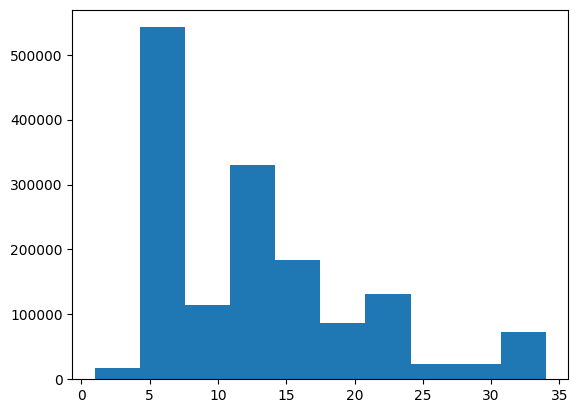

Before undersampling:  Counter({219: 469453, 100: 171403, 55: 97889, 216: 90012, 220: 56823, 129: 41846, 31: 29963, 99: 25677, 59: 17695, 217: 17661, 218: 16362, 158: 16348, 92: 14774, 103: 13932, 132: 12757, 117: 7634, 215: 7467, 181: 6472, 39: 6248, 50: 5881, 98: 5281, 205: 5217, 81: 4580, 138: 4260, 56: 4215, 13: 3855, 202: 3855, 73: 3750, 164: 3460, 206: 3400, 32: 3342, 137: 3329, 85: 3292, 154: 3081, 106: 3051, 178: 2989, 4: 2980, 187: 2919, 212: 2881, 125: 2878, 130: 2871, 101: 2835, 173: 2827, 102: 2825, 155: 2824, 186: 2792, 195: 2774, 109: 2739, 123: 2699, 160: 2694, 194: 2692, 197: 2685, 145: 2684, 177: 2683, 149: 2676, 127: 2668, 189: 2644, 185: 2643, 162: 2642, 191: 2621, 196: 2619, 182: 2619, 131: 2611, 105: 2603, 190: 2598, 188: 2595, 115: 2593, 153: 2589, 198: 2583, 184: 2576, 120: 2576, 176: 2575, 201: 2571, 156: 2567, 165: 2566, 200: 2563, 193: 2562, 152: 2558, 135: 2553, 192: 2553, 175: 2552, 180: 2551, 163: 2549, 144: 2548, 133: 2539, 141: 2538, 108: 2535, 134: 2533,

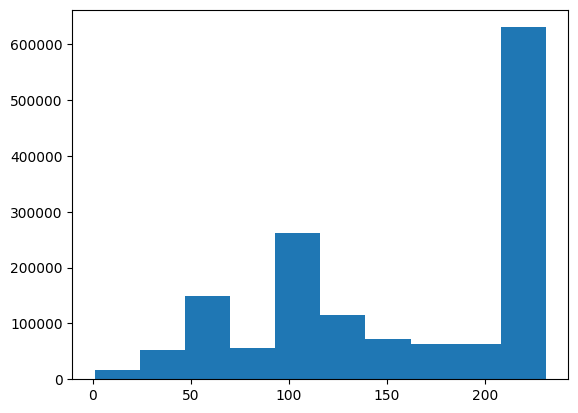

Before undersampling:  Counter({219: 566876, 100: 95494, 55: 56243, 99: 42732, 31: 41516, 129: 28524, 216: 27110, 215: 27015, 220: 23610, 98: 17918, 59: 16135, 158: 14190, 205: 10285, 117: 9917, 132: 9709, 103: 9666, 92: 9620, 217: 9408, 39: 9033, 218: 8222, 202: 7960, 81: 7114, 109: 6641, 73: 6182, 164: 5706, 15: 5591, 32: 5565, 56: 5515, 181: 5324, 138: 4945, 70: 4836, 14: 4798, 4: 4741, 41: 4714, 225: 4251, 60: 4189, 154: 4189, 157: 3876, 50: 3804, 137: 3488, 212: 3455, 145: 3363, 213: 3358, 206: 3335, 211: 3297, 80: 3262, 178: 3238, 156: 2993, 127: 2905, 221: 2893, 102: 2805, 53: 2799, 194: 2793, 35: 2791, 162: 2734, 125: 2680, 106: 2668, 187: 2656, 182: 2630, 159: 2538, 200: 2535, 186: 2532, 113: 2524, 189: 2518, 149: 2518, 152: 2505, 193: 2502, 196: 2497, 161: 2489, 195: 2487, 173: 2484, 185: 2475, 214: 2470, 165: 2464, 119: 2462, 177: 2461, 155: 2455, 203: 2449, 171: 2436, 151: 2435, 184: 2430, 207: 2427, 175: 2420, 191: 2420, 192: 2418, 160: 2418, 188: 2412, 197: 2400, 183: 239

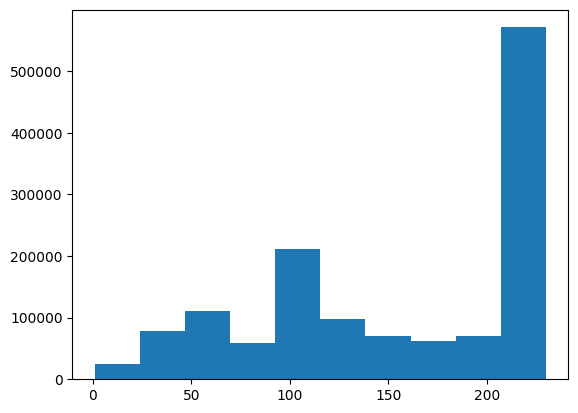

Before undersampling:  Counter({1: 654817, 2: 322148, 3: 174912, 4: 87900, 5: 42816, 7: 25437, 6: 23837, 8: 7807, 9: 4510, 10: 4021, 14: 3096, 11: 2114, 12: 1499, 13: 1225, 15: 699, 16: 368, 21: 337, 17: 284, 18: 203, 19: 192, 20: 144, 28: 138, 22: 96, 24: 85, 25: 77, 26: 62, 27: 59, 23: 51, 34: 6, 57: 3, 41: 3, 44: 3, 30: 2, 33: 2, 29: 1})
After undersampling:  Counter({1: 403990, 2: 322148, 3: 174912, 4: 87900, 5: 42816, 7: 25437, 6: 23837, 8: 7807, 9: 4510, 10: 4021, 14: 3096, 11: 2114, 12: 1499, 13: 1225, 15: 699, 16: 368, 21: 337, 17: 284, 18: 203, 19: 192, 20: 144, 28: 138, 22: 96, 24: 85, 25: 77, 26: 62, 27: 59, 23: 51, 34: 6, 41: 3, 44: 3, 57: 3, 30: 2, 33: 2, 29: 1})


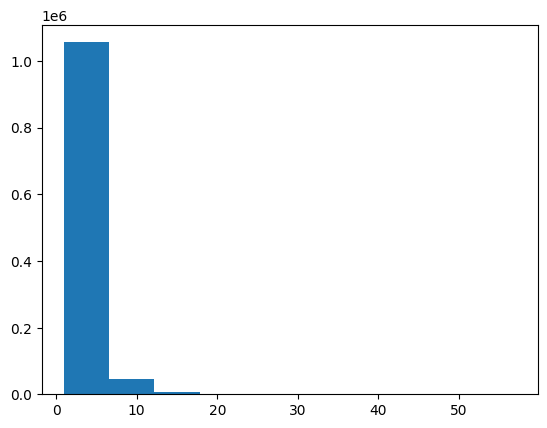

In [443]:
to_under_sample = ["site_id", 
                   "visitor_location_country_id", 
                   "prop_country_id", 
                   "srch_length_of_stay"]

end_df = undersampled

alpha = 0.5
for under in to_under_sample:
    end_df = undersample_multi_data(end_df, under, alpha)
    plt.hist(end_df[under])
    plt.show()


### Detecting outliers and treating them

In [444]:
import pandas as pd
import numpy as np

# Filter out non-numeric columns
df_numeric = end_df

for column in df_numeric.select_dtypes(include=['float64']):
    Q1 = df_numeric[column].quantile(0.25)
    Q3 = df_numeric[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define a mask for values outside the IQR
    mask = ((df_numeric[column] < (Q1 - 1.5 * IQR)) | (df_numeric[column] > (Q3 + 1.5 * IQR)))
    
    # Replace outliers with NaN
    df_numeric.loc[mask, column] = np.nan

df_numeric.isna().sum()

srch_id                            0
visitor_hist_adr_usd           94427
prop_id                            0
prop_starrating                    0
prop_review_score              62394
prop_brand_bool                    0
prop_location_score1               0
prop_location_score2           58440
srch_adults_count                  0
srch_room_count                    0
srch_saturday_night_bool           0
click_bool                         0
gross_bookings_usd             86470
booking_stay                   34139
booking_bool                       0
site_id                            0
visitor_location_country_id        0
prop_country_id                    0
srch_length_of_stay                0
dtype: int64

In [445]:
# Impute/Replace NaN values with means
df_numeric.fillna(df_numeric.mean(), inplace=True)
df_numeric.head()

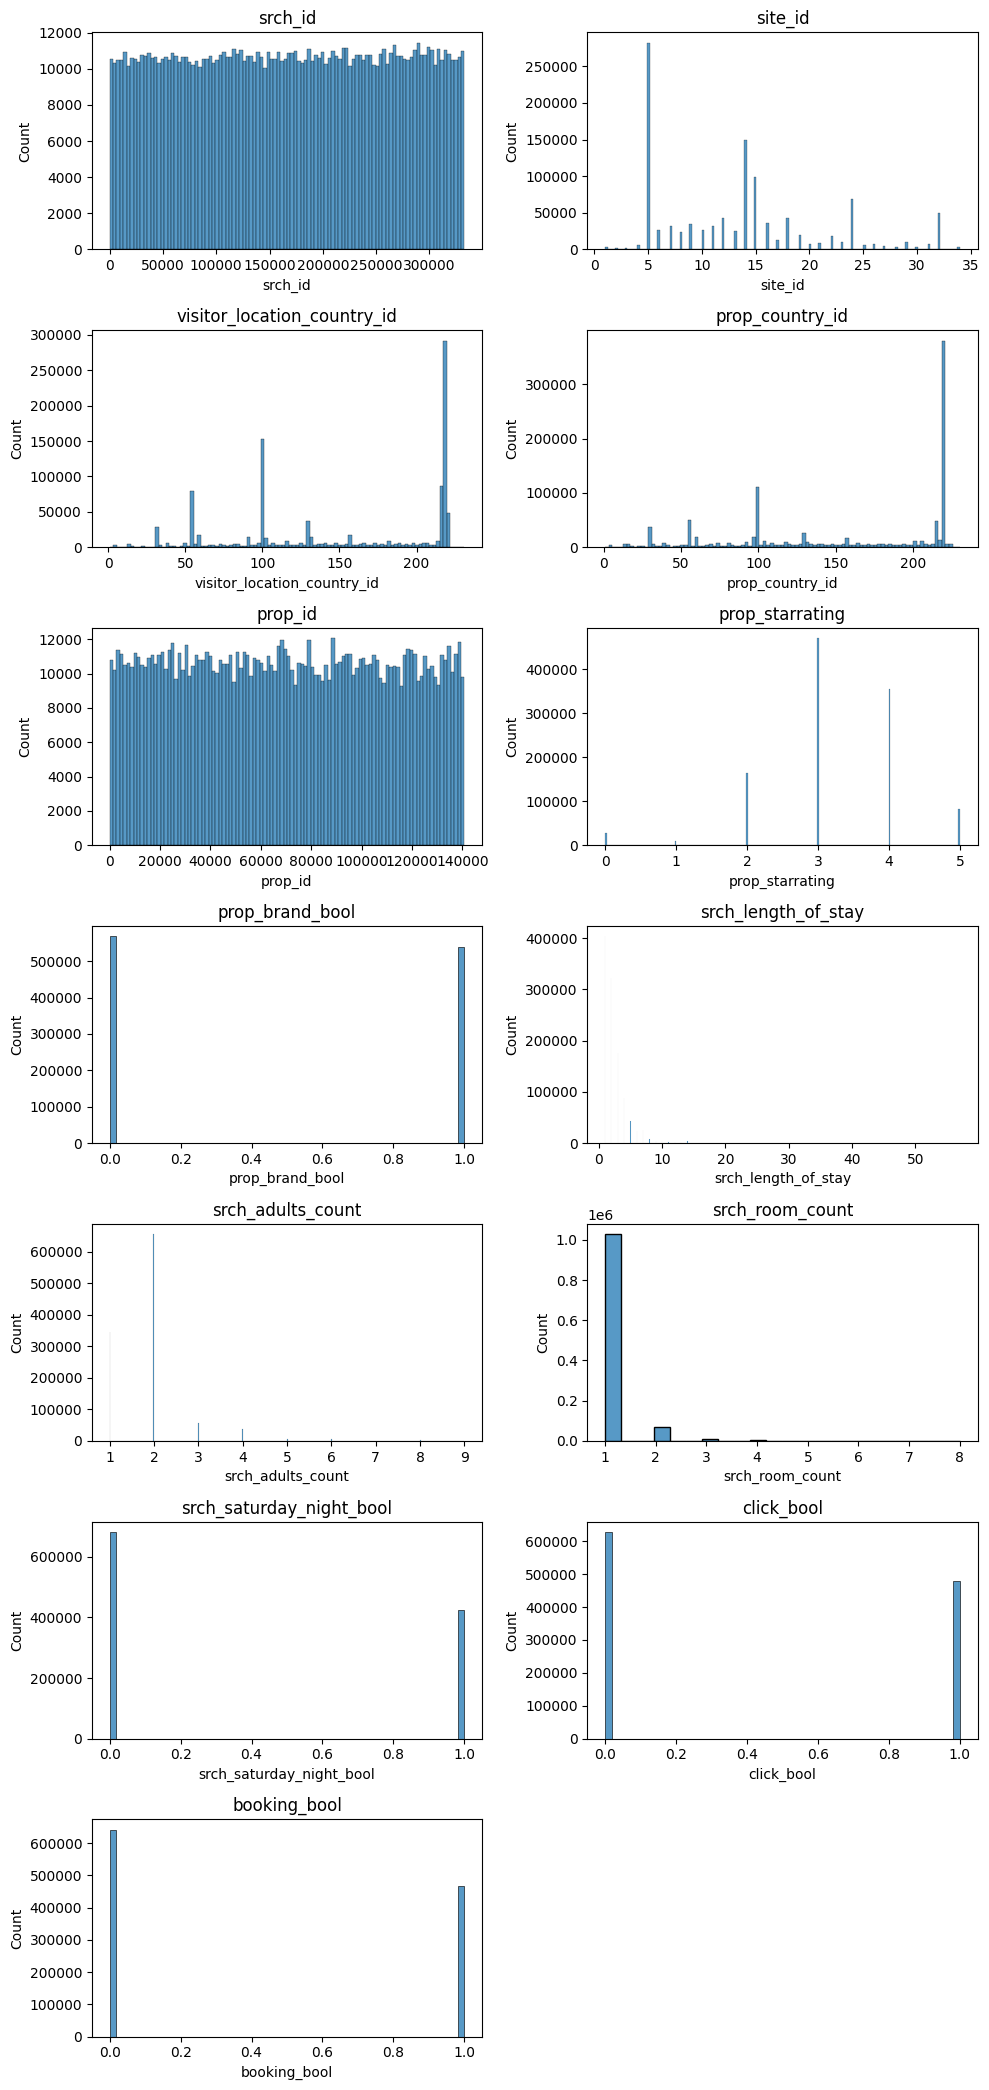

In [454]:
plot_data(df_numeric[int_cols.columns], False)

(array([6.41004e+05, 1.80000e+01, 3.40000e+01, 7.50000e+01, 1.01000e+02,
        1.84000e+02, 2.48000e+02, 4.36000e+02, 6.87000e+02, 1.10000e+03,
        1.54400e+03, 2.31100e+03, 2.85300e+03, 3.83900e+03, 4.42500e+03,
        5.26200e+03, 9.22680e+04, 6.40300e+03, 6.98800e+03, 7.36600e+03,
        7.55700e+03, 7.53800e+03, 7.61800e+03, 7.83900e+03, 7.75100e+03,
        7.82400e+03, 7.67400e+03, 7.40700e+03, 7.27200e+03, 7.19800e+03,
        6.99700e+03, 6.92300e+03, 6.74900e+03, 6.62700e+03, 6.61000e+03,
        6.44300e+03, 6.30400e+03, 6.06900e+03, 6.13900e+03, 5.87800e+03,
        5.75000e+03, 5.67700e+03, 5.66200e+03, 5.45400e+03, 5.27600e+03,
        5.16300e+03, 5.10700e+03, 5.07500e+03, 4.91000e+03, 4.74700e+03,
        4.63800e+03, 4.67300e+03, 4.59700e+03, 4.35200e+03, 4.24200e+03,
        4.17400e+03, 4.11500e+03, 3.90100e+03, 3.88400e+03, 3.75100e+03,
        3.76000e+03, 3.54700e+03, 3.47700e+03, 3.61500e+03, 3.43900e+03,
        3.19700e+03, 3.21100e+03, 3.08800e+03, 3.07

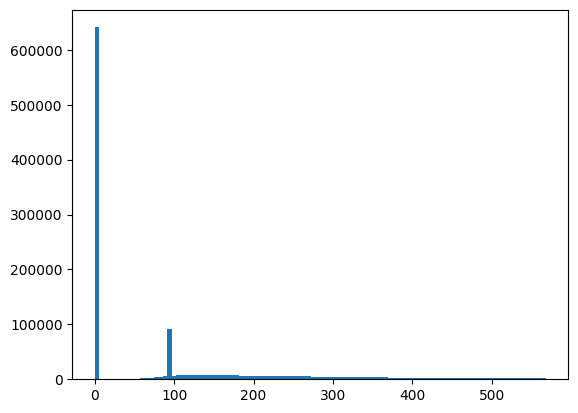

In [450]:
# Undersample the gross_bookings_usd
abc = dropped_new_training.loc[dropped_new_training["gross_bookings_usd"] > 0]
plt.hist(end_df["gross_bookings_usd"], bins=100)

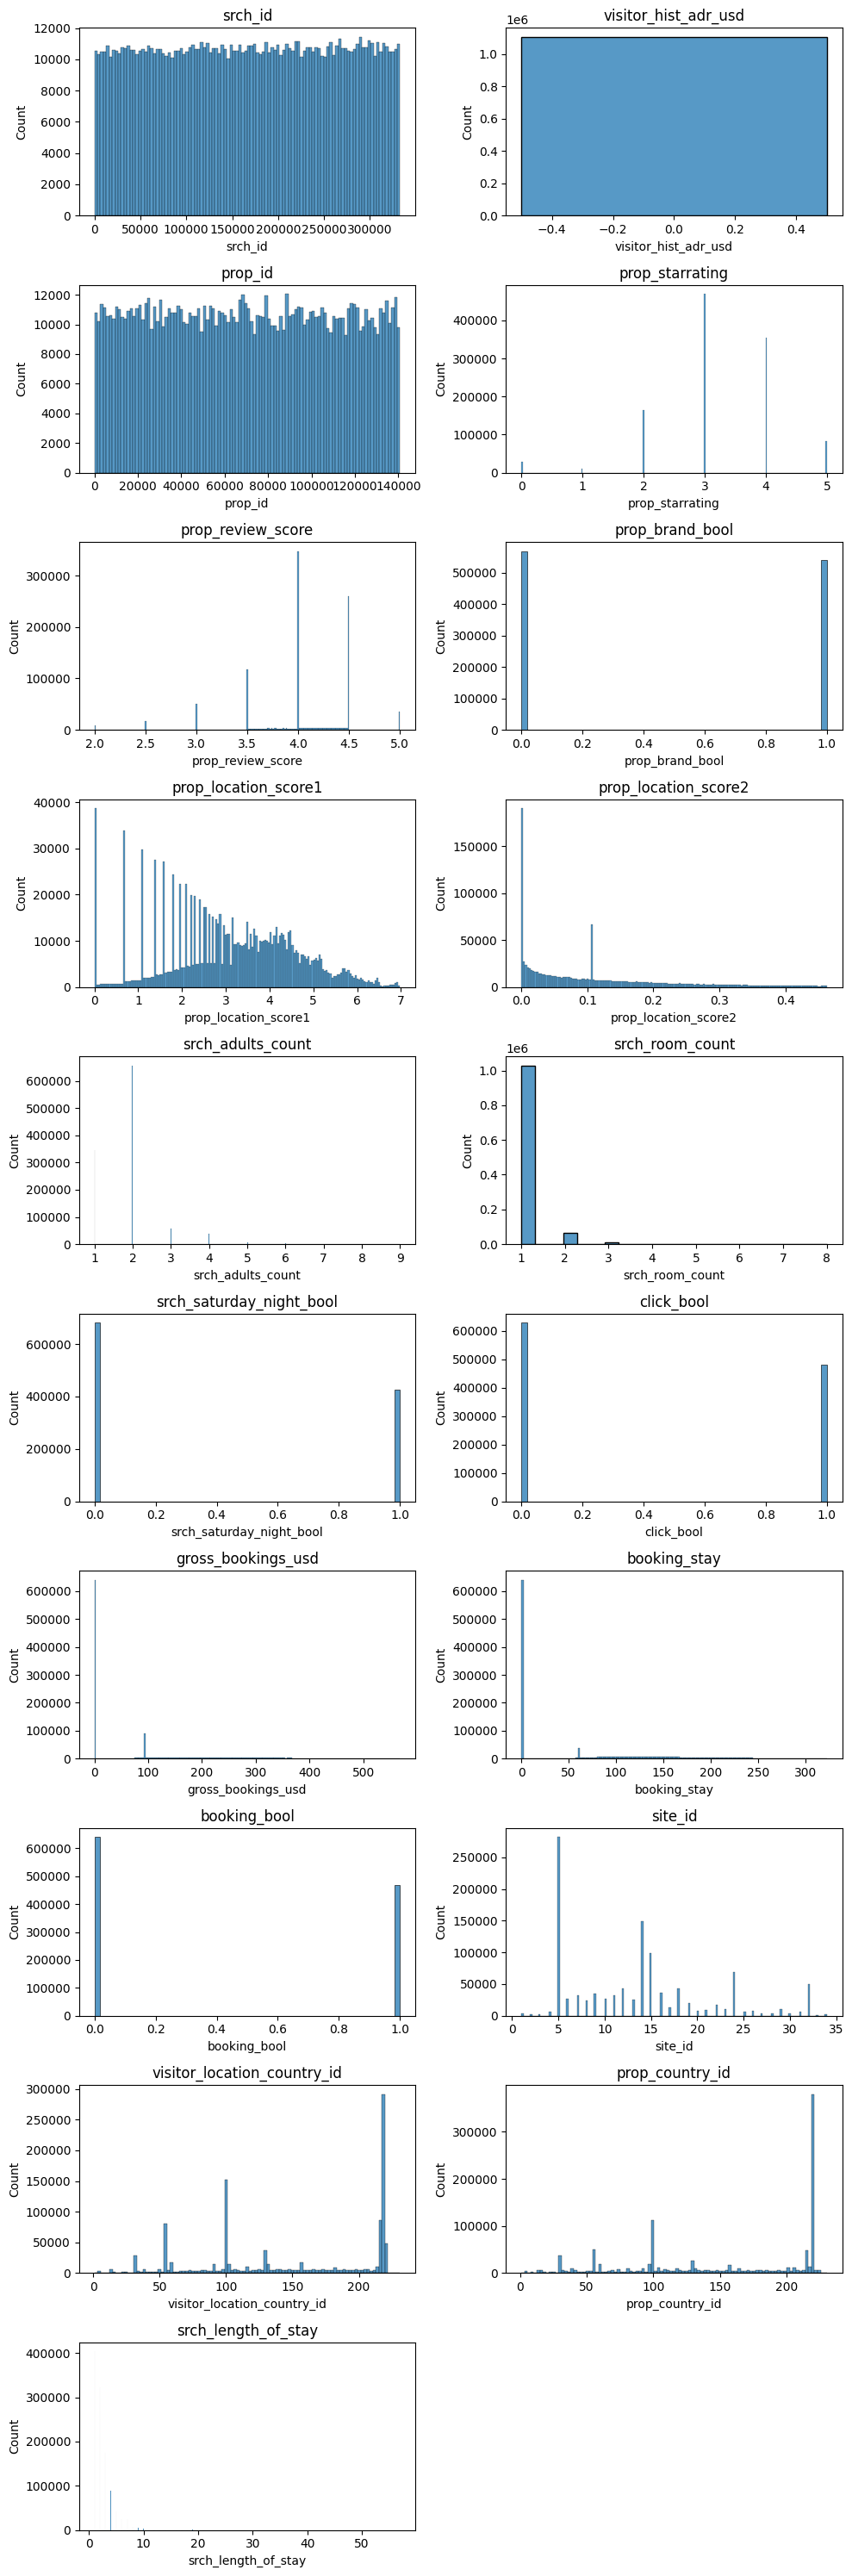

In [451]:
# Filter non numeric values
plot_data(end_df, False)

In [486]:
# Standardize data
cols_to_scale = ['visitor_hist_adr_usd', 'prop_starrating', 'prop_review_score', 'prop_location_score1', 'prop_location_score2', 'srch_adults_count', 'srch_room_count', 'gross_bookings_usd', 'booking_stay', 'srch_length_of_stay']
df_scale, df_other = end_df[cols_to_scale].reset_index(), end_df.drop(cols_to_scale, axis=1).reset_index()

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_scale), columns=df_scale.columns)
new_df = pd.concat([df_scaled, df_other], axis=1)


In [490]:
# Save the data
new_df.to_csv("cleaned_data.csv")

<BarContainer object of 21 artists>

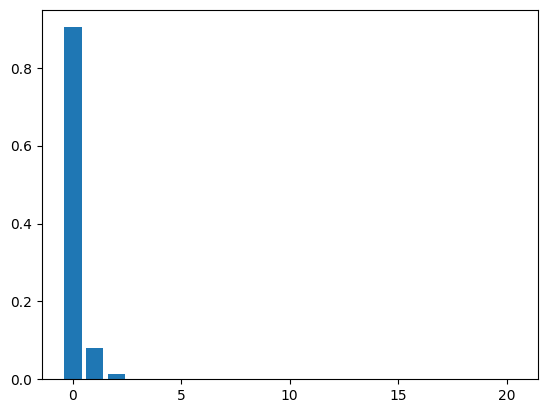

In [485]:
from sklearn.decomposition import PCA

pca = PCA()
dat = pca.fit_transform(new_df)
explained_variance = pca.explained_variance_ratio_
var_dat = pd.DataFrame({'variance':explained_variance})
plt.bar(var_dat.index,var_dat['variance'])

In [460]:
print(pca)


PCA()
